<a href="https://colab.research.google.com/github/Asoub2001/multi-class-tweet-classifier/blob/main/twitter_topic_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
# Data manipulation & utilities
import pandas as pd
import numpy as np
import re
import time
import joblib
import os


# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text processing & vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

# Dimensionality reduction (optional)
from sklearn.decomposition import PCA

# Train/test split
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)

# Label preprocessing for ROC/PR curves
from sklearn.preprocessing import label_binarize


In [3]:
# Load the Data
# Load the JSON dataset into a pandas DataFrame
data = pd.read_json('/content/CETM47_24_5-AS2-Data.json')

#  Preview the data before cleaning (display the first 5 rows)
print("Data Preview Before Cleaning:")
print(data[['text']].head())  # Show the first 5 tweets


Data Preview Before Cleaning:
                                                text
0  The {@Clinton LumberKings@} beat the {@Cedar R...
1  I would rather hear Eli Gold announce this Aub...
2  Someone take my phone away, I’m trying to not ...
3  A year ago, Louisville struggled to beat an FC...
4  Anyone know why the #Dodgers #Orioles game nex...


In [5]:
# Check for null values in the dataset
print(data.isnull().sum())


text          0
date          0
label         0
id            0
label_name    0
dtype: int64


In [13]:
# Check for duplicate rows
print(f"Number of duplicate rows: {data.duplicated().sum()}")


Number of duplicate rows: 0


In [61]:
# Data Preprocessing
# Function to clean the tweet text by removing URLs, user mentions, and special characters
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+", '', text)

    # Keep mentions and hashtags (they carry meaning in tweets)
    text = re.sub(r"[^a-zA-Z0-9\s@#]", '', text)

    # Convert to lowercase
    return text.lower()


    # Return the cleaned text
    return text

# Apply the cleaning function to the 'text' column and store the results in a new column
data['cleaned_text'] = data['text'].apply(clean_text)

# Preview the data after cleaning (display the first 5 rows)
print("\nData Preview After Cleaning:")
print(data[['text', 'cleaned_text']].head())  # Show original and cleaned tweets side by side


Data Preview After Cleaning:
                                                text  \
0  The {@Clinton LumberKings@} beat the {@Cedar R...   
1  I would rather hear Eli Gold announce this Aub...   
2  Someone take my phone away, I’m trying to not ...   
3  A year ago, Louisville struggled to beat an FC...   
4  Anyone know why the #Dodgers #Orioles game nex...   

                                        cleaned_text  
0  the @clinton lumberkings@ beat the @cedar rapi...  
1  i would rather hear eli gold announce this aub...  
2  someone take my phone away im trying to not lo...  
3  a year ago louisville struggled to beat an fcs...  
4  anyone know why the #dodgers #orioles game nex...  


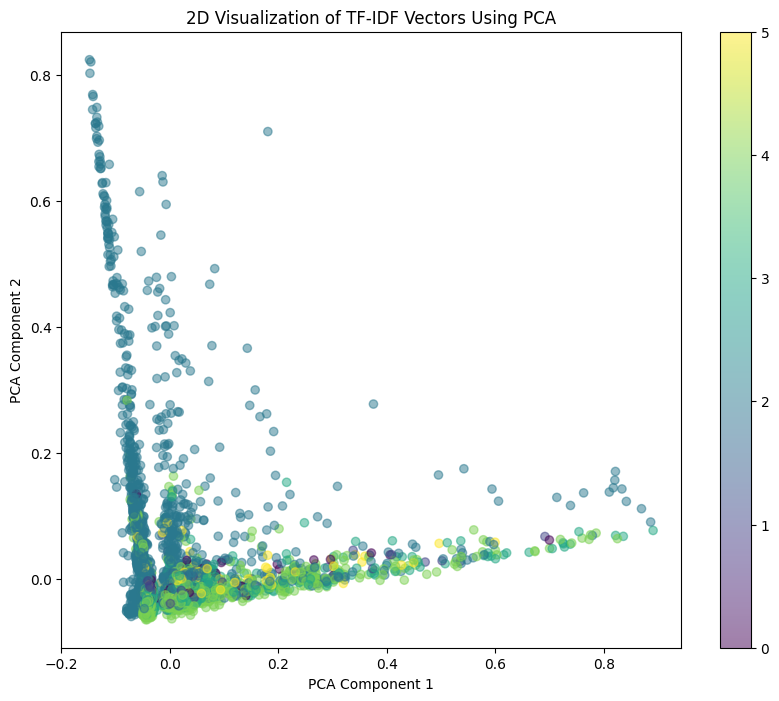

In [62]:

# Text Vectorization
# Convert the cleaned text into numerical representations using TF-IDF (Term Frequency-Inverse Document Frequency)
# TF-IDF helps represent the text as a sparse matrix of numeric features that can be used for machine learning
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.9, min_df=3, stop_words='english')
X = vectorizer.fit_transform(data['cleaned_text'])  # Apply the vectorizer to the cleaned text

# Reduce dimensionality using PCA to 2 components
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
X_pca = pca.fit_transform(X.toarray())  # Perform PCA on the dense representation of TF-IDF

# Plot the results
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, c=data['label'], cmap='viridis')  # Scatter plot
plt.colorbar()  # Add a color bar to indicate the labels
plt.title("2D Visualization of TF-IDF Vectors Using PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [63]:
# Split the Data
# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, data['label'], test_size=0.2, random_state=42)

In [64]:
# Train the Classifiers
# Train a Naive Bayes classifier
nb_model = MultinomialNB()  # Create an instance of the Naive Bayes model
nb_model.fit(X_train, y_train)  # Train the model using the training data

MultinomialNB()

In [65]:
# Logistic Regression Tuning
from sklearn.model_selection import GridSearchCV

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced']
}

lr_grid = GridSearchCV(LogisticRegression(max_iter=200), lr_params, cv=3, scoring='accuracy', n_jobs=-1)
lr_grid.fit(X_train, y_train)
lr_model = lr_grid.best_estimator_
print(f"\nBest Logistic Regression Params: {lr_grid.best_params_}")



Best Logistic Regression Params: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


In [66]:
# SVM Tuning
from sklearn.svm import LinearSVC

svm_params = {
    'C': [0.01, 0.1, 1, 10],
    'class_weight': ['balanced']
}

svm_grid = GridSearchCV(LinearSVC(), svm_params, cv=3, scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_train)
svm_model = svm_grid.best_estimator_
print(f"\nBest SVM Params: {svm_grid.best_params_}")



Best SVM Params: {'C': 1, 'class_weight': 'balanced'}


In [67]:
# Model Evaluation
# Evaluate the Naive Bayes model on the test data
nb_predictions = nb_model.predict(X_test)  # Predict using the Naive Bayes model
# Print the performance metrics (accuracy, classification report, confusion matrix)
print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_predictions))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, nb_predictions))
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_test, nb_predictions))

Naive Bayes Accuracy: 0.747866563227308
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       1.00      0.08      0.15        60
           2       0.70      0.92      0.80       497
           3       0.77      0.30      0.43       179
           4       0.79      0.95      0.86       468
           5       0.71      0.08      0.15        60

    accuracy                           0.75      1289
   macro avg       0.66      0.39      0.40      1289
weighted avg       0.75      0.75      0.70      1289

Naive Bayes Confusion Matrix:
[[  0   0  19   2   4   0]
 [  0   5  25   9  20   1]
 [  0   0 455   2  39   1]
 [  0   0  89  54  36   0]
 [  0   0  23   0 445   0]
 [  0   0  35   3  17   5]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [68]:
# Evaluate the Logistic Regression model on the test data
lr_predictions = lr_model.predict(X_test)  # Predict using the Logistic Regression model
# Print the performance metrics (accuracy, classification report, confusion matrix)
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_predictions))
print("Logistic Regression Confusion Matrix:")
print(confusion_matrix(y_test, lr_predictions))


Logistic Regression Accuracy: 0.8254460822342902
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50        25
           1       0.77      0.50      0.61        60
           2       0.86      0.85      0.86       497
           3       0.66      0.72      0.69       179
           4       0.88      0.92      0.90       468
           5       0.72      0.65      0.68        60

    accuracy                           0.83      1289
   macro avg       0.76      0.67      0.71      1289
weighted avg       0.82      0.83      0.82      1289

Logistic Regression Confusion Matrix:
[[ 10   0   7   4   3   1]
 [  0  30   6  11  10   3]
 [  1   1 424  33  32   6]
 [  1   6  29 129  11   3]
 [  0   1  21  12 432   2]
 [  3   1   6   7   4  39]]


In [69]:
# Evaluate the SVM model on the test data
svm_predictions = svm_model.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))
print("SVM Classification Report:")
print(classification_report(y_test, svm_predictions))
print("SVM Confusion Matrix:")
print(confusion_matrix(y_test, svm_predictions))


SVM Accuracy: 0.8238944918541505
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.48      0.56        25
           1       0.66      0.55      0.60        60
           2       0.87      0.84      0.86       497
           3       0.64      0.70      0.67       179
           4       0.89      0.93      0.91       468
           5       0.67      0.67      0.67        60

    accuracy                           0.82      1289
   macro avg       0.73      0.69      0.71      1289
weighted avg       0.82      0.82      0.82      1289

SVM Confusion Matrix:
[[ 12   0   4   5   3   1]
 [  0  33   5  11   8   3]
 [  1   3 418  34  30  11]
 [  2  10  29 125  10   3]
 [  0   2  17  13 434   2]
 [  3   2   5   7   3  40]]



✅ Model Accuracies (as percentage):
Naive Bayes Accuracy: 74.79%
Logistic Regression Accuracy: 82.54%
SVM Accuracy: 82.39%


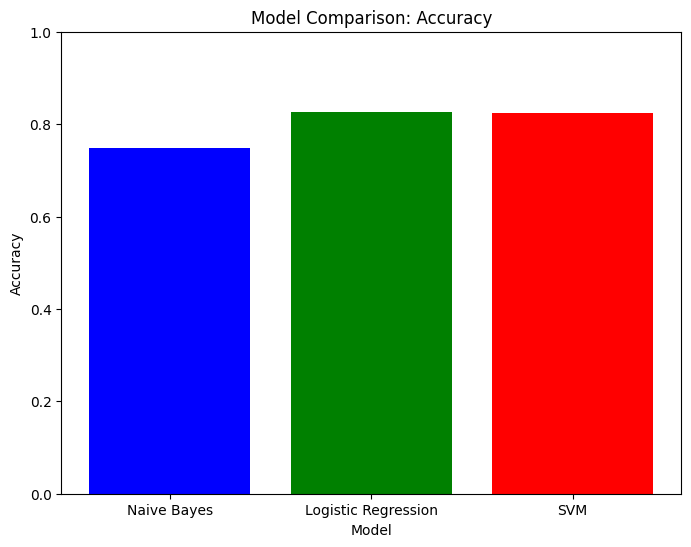

In [70]:
# Calculate accuracy as percentage
nb_accuracy = accuracy_score(y_test, nb_predictions) * 100
lr_accuracy = accuracy_score(y_test, lr_predictions) * 100
svm_accuracy = accuracy_score(y_test, svm_predictions) * 100

# Print all accuracies
print(f"\n✅ Model Accuracies (as percentage):")
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}%")
print(f"Logistic Regression Accuracy: {lr_accuracy:.2f}%")
print(f"SVM Accuracy: {svm_accuracy:.2f}%")


# Model names and their accuracy scores
models = ['Naive Bayes', 'Logistic Regression', 'SVM']
accuracies = [
    accuracy_score(y_test, nb_predictions),
    accuracy_score(y_test, lr_predictions),
    accuracy_score(y_test, svm_predictions)
]


# Plotting the comparison
plt.figure(figsize=(8, 6))
plt.bar(models, accuracies, color=['blue', 'green','red'])
plt.title('Model Comparison: Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.show()

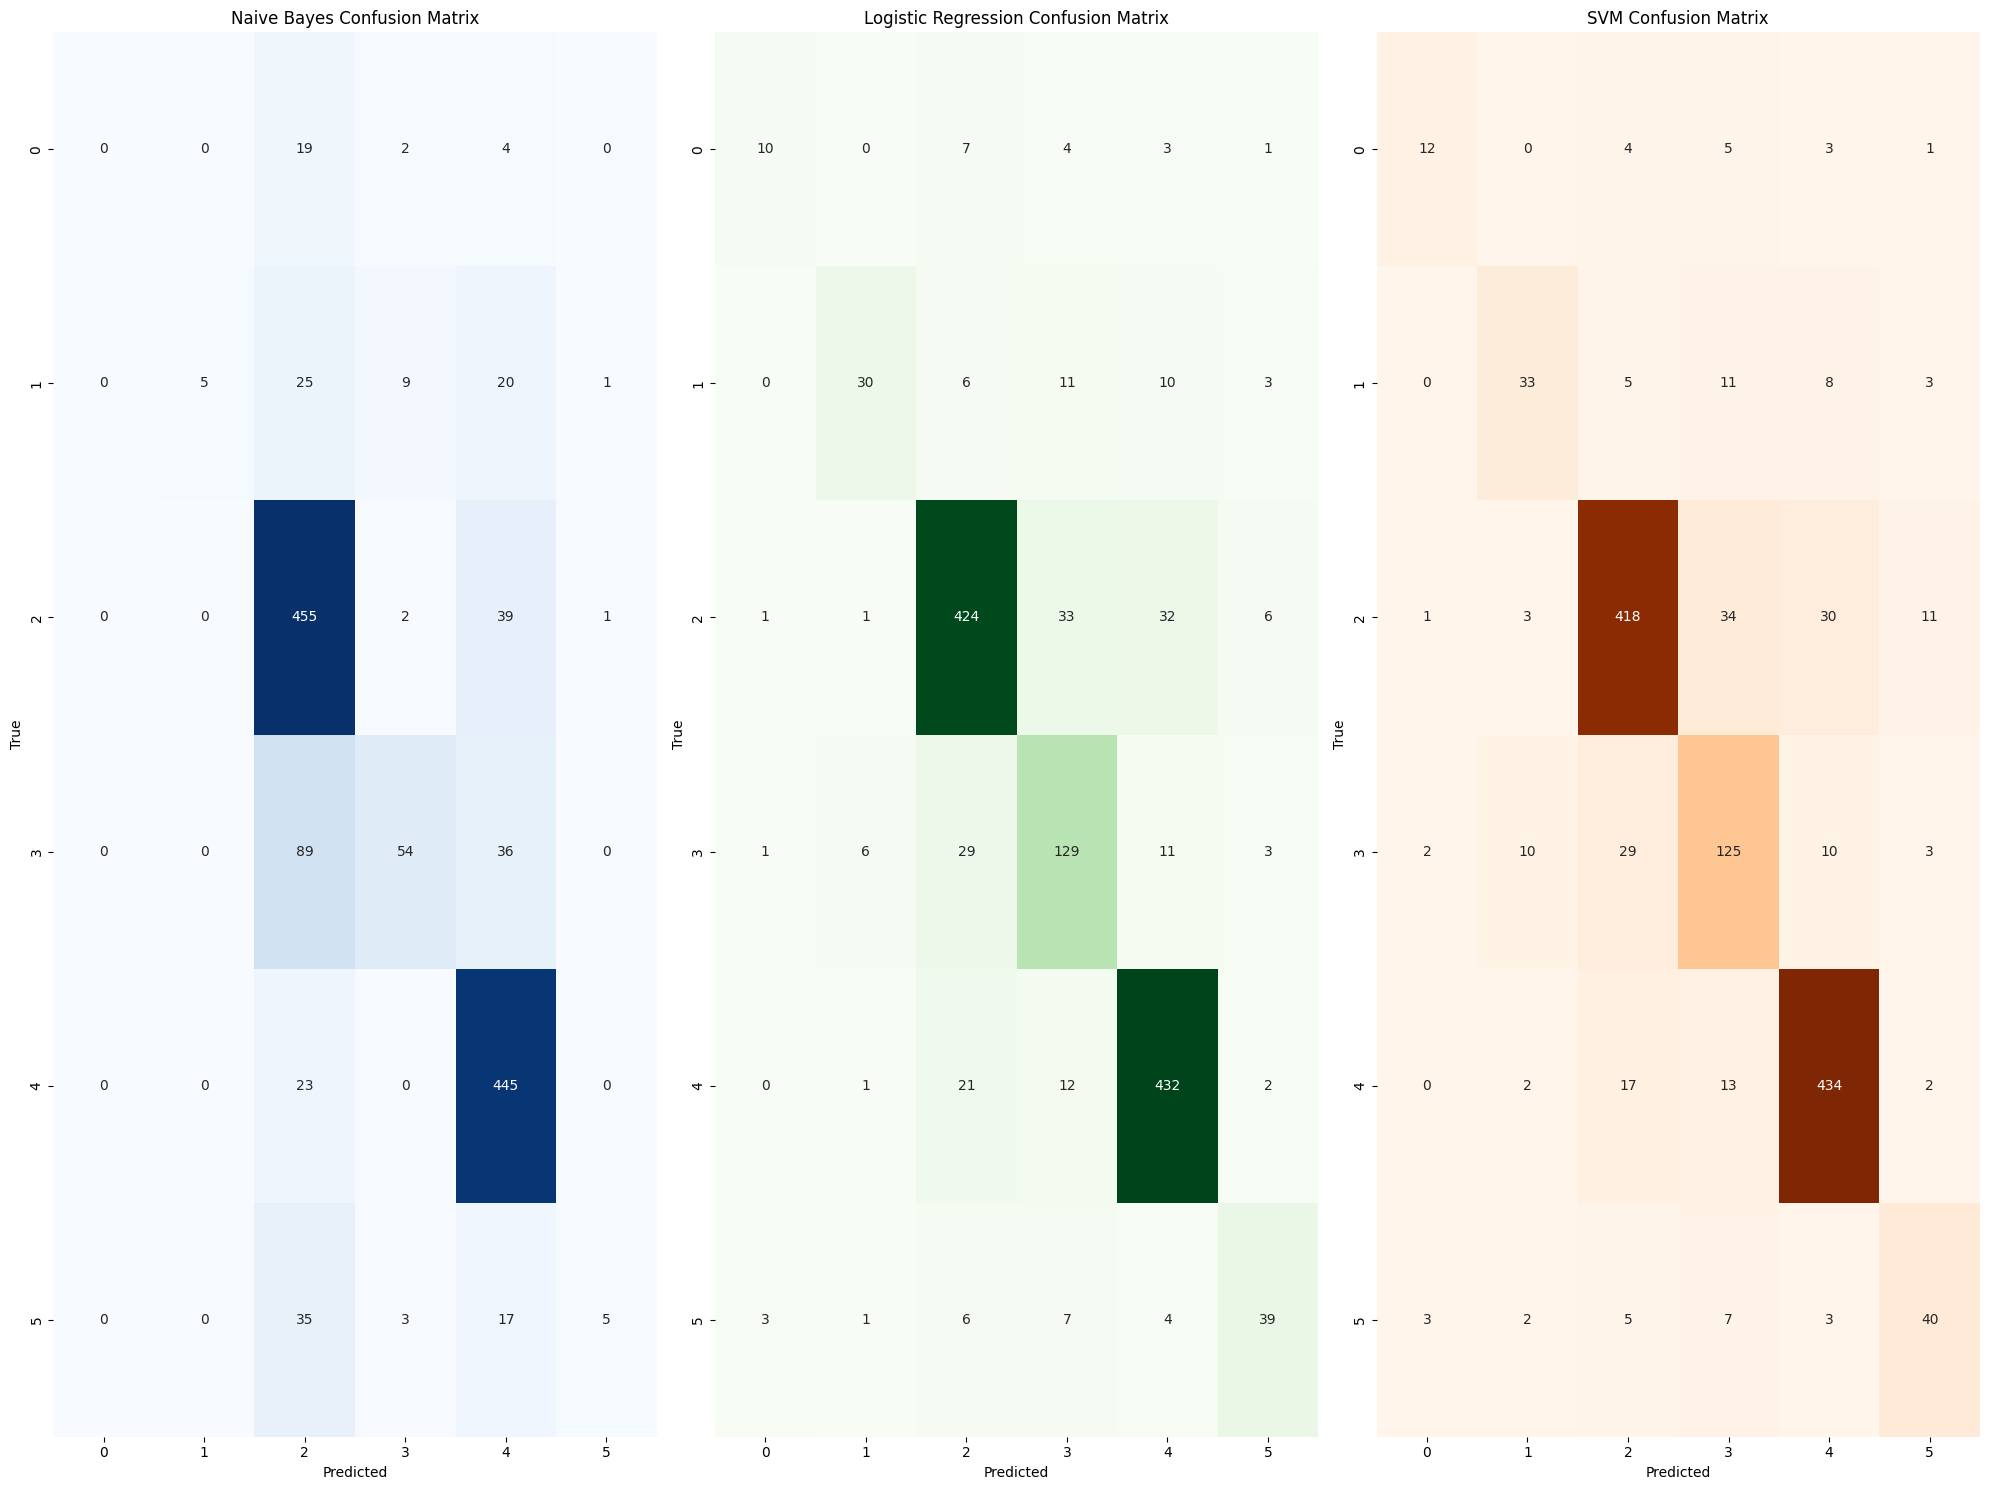

In [72]:


# Generate confusion matrices for both models
nb_cm = confusion_matrix(y_test, nb_predictions)
lr_cm = confusion_matrix(y_test, lr_predictions)
svm_cm = confusion_matrix(y_test, svm_predictions)


# Plotting the confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(20, 15))

# Naive Bayes Confusion Matrix
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title('Naive Bayes Confusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Logistic Regression Confusion Matrix
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title('Logistic Regression Confusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')

# SVM Confusion Matrix
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Oranges', ax=axes[2], cbar=False)
axes[2].set_title('SVM Confusion Matrix')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('True')


plt.tight_layout()
plt.show()

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Prepare metrics for each model
models_summary = {
    'Naive Bayes': nb_predictions,
    'Logistic Regression': lr_predictions,
    'SVM': svm_predictions
}

print("\nModel Performance Summary:\n")
print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("Model", "Accuracy", "Precision", "Recall", "F1"))
for name, preds in models_summary.items():
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='macro')
    rec = recall_score(y_test, preds, average='macro')
    f1 = f1_score(y_test, preds, average='macro')
    print("{:<20} {:.4f}    {:.4f}    {:.4f}    {:.4f}".format(name, acc, prec, rec, f1))



Model Performance Summary:

Model                Accuracy   Precision  Recall     F1        
Naive Bayes          0.7479    0.6639    0.3891    0.3997
Logistic Regression  0.8254    0.7591    0.6745    0.7058
SVM                  0.8239    0.7330    0.6939    0.7098


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


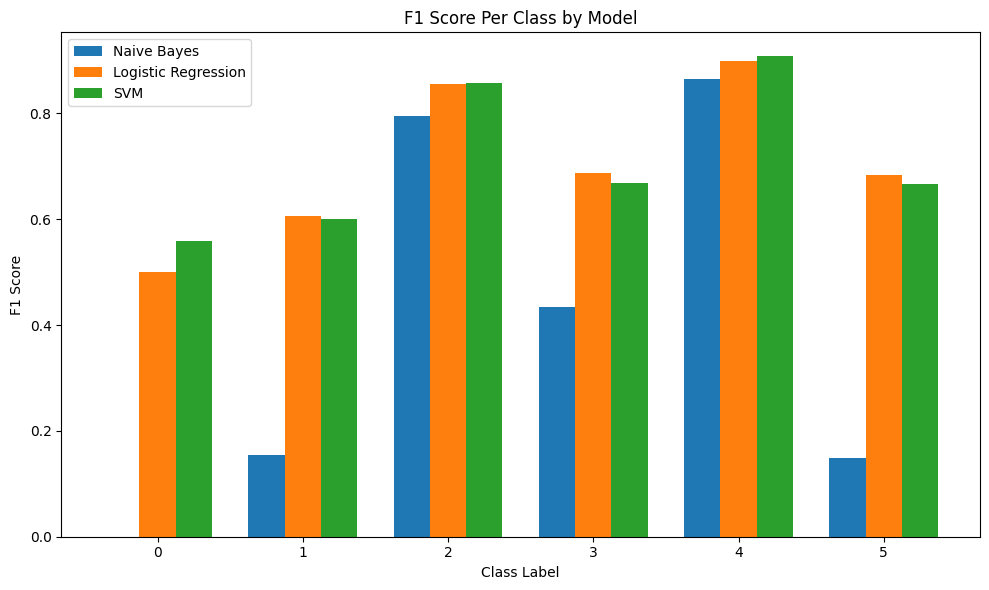

In [74]:
import numpy as np

labels = [0, 1, 2, 3, 4, 5]
nb_f1 = f1_score(y_test, nb_predictions, average=None, labels=labels)
lr_f1 = f1_score(y_test, lr_predictions, average=None, labels=labels)
svm_f1 = f1_score(y_test, svm_predictions, average=None, labels=labels)

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(10, 6))
plt.bar(x - width, nb_f1, width, label='Naive Bayes')
plt.bar(x, lr_f1, width, label='Logistic Regression')
plt.bar(x + width, svm_f1, width, label='SVM')
plt.xlabel('Class Label')
plt.ylabel('F1 Score')
plt.title('F1 Score Per Class by Model')
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()


In [75]:
# Train the Classifiers with Execution Time Measurement

# 1. Naive Bayes
start_time = time.time()
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_train_time = time.time() - start_time
print(f"Naive Bayes Training Time: {nb_train_time:.4f} seconds")

# 2. Logistic Regression
start_time = time.time()
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
lr_train_time = time.time() - start_time
print(f"Logistic Regression Training Time: {lr_train_time:.4f} seconds")

# 3. SVM (Linear Support Vector Machine)
start_time = time.time()
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
svm_train_time = time.time() - start_time
print(f"SVM Training Time: {svm_train_time:.4f} seconds")


Naive Bayes Training Time: 0.0081 seconds
Logistic Regression Training Time: 3.1694 seconds
SVM Training Time: 0.1788 seconds


In [78]:
# Create a dictionary of models
trained_models = {
    'NaiveBayes': nb_model,
    'LogisticRegression': lr_model,
    'SVM': svm_model
}

os.makedirs('models', exist_ok=True)

# Save to file
joblib.dump(trained_models, 'models/trained_models.pkl')
print("✅ Models saved to 'models/trained_models.pkl'")


✅ Models saved to 'models/trained_models.pkl'
